In [24]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import roberts, sobel, scharr, prewitt, farid
from scipy import ndimage
from time import sleep

In [23]:
def display(img,title=''):
    plt.figure(figsize=(5,5))
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

# function for creating an image
def create_img():
    blank_img = cv.imread('./img/lady.png')
    # blank_img=cv.cvtColor(blank_img,cv.COLOR_BAYER_BG2GRAY)
    # font = cv.FONT_HERSHEY_DUPLEX
    # cv.putText(img=blank_img, 
    #             text='H', 
    #             org=(50,150), 
    #             fontFace=font, 
    #             fontScale=5, 
    #             color=(255,255,255),
    #             thickness=25,
    #             lineType=cv.LINE_AA)
    return blank_img

- Steerable derivative\
$df=\cos(\theta).dx+\sin(\theta).dy$

- Normal derivative\
$df=\sqrt{dx^2+dy^2}$

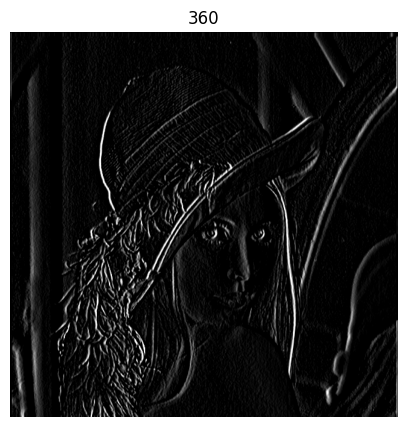

In [28]:
# sobel kernel

from IPython.display import clear_output
sobel_y = np.array([[1, 2, 1],
                    [ 0,  0,  0],
                    [ -1,  -2,  -1]])

sobel_x= np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

# input image
blank_img = cv.imread('./img/lady.png')
blank_img=cv.cvtColor(blank_img,cv.COLOR_BGR2GRAY)
# display(i)
# partial derivative in x-direction
# edge_x=ndimage.convolve(blank_img,sobel_x,mode='nearest')
edge_x = cv.filter2D(src=blank_img, ddepth=-1, kernel=sobel_x)
# display(edge_x)

# edge_x[edge_x != 0] = 255
# display(edge_x)

# partial derivative in y-direction
edge_y = cv.filter2D(src=blank_img, ddepth=-1, kernel=sobel_y)
# edge_y=ndimage.convolve(blank_img,sobel_y,mode='constant',origin=-1)
# display(edge_y)
# edge_y[edge_y != 0] = 255
# display(edge_y)

# combinte the x and y edge
for th in range(0,361,5):
    display(np.cos(np.radians(th))*edge_x+np.sin(np.radians(th))*edge_y,th)
    sleep(0.1)
    clear_output(wait=True)
# add_edge = np.sqrt(edge_x.astype(float)**2 + edge_y.astype(float)**2)
# display(add_edge.astype(int))
# add_edge[add_edge != 0] = 255
# display(add_edge)

### Check difference between two methods → should use filter2D for edge detection

In [117]:
test_img=np.array([
    [1, 2, 3, 4, 5],
    [6, 7, 8, 9, 1],
    [2, 3, 4, 5, 6],
    [7, 8, 9, 1, 2],
    [3, 4, 5, 6, 7]
], dtype=np.float64)
ndimage.convolve(test_img,sobel_x,mode='constant'),cv.filter2D(src=test_img, ddepth=-1, kernel=sobel_x)

(array([[-19., -28., -32., -27., -11.],
        [ -3.,  -4.,  -4.,  -4.,  -3.],
        [ -3.,  -4.,   5.,  14.,   6.],
        [ -3.,  -4.,  -4.,  -4.,  -3.],
        [ 22.,  32.,  27.,  13.,   5.]]),
 array([[  0.,   0.,   0.,   0.,   0.],
        [  4.,   4.,   4.,   4.,   4.],
        [  4.,   4.,  -5., -14., -14.],
        [  4.,   4.,   4.,   4.,   4.],
        [  0.,   0.,   0.,   0.,   0.]]))

In [194]:
#Autocanny
sigma = 0.1
median = np.median(blank_img)

# apply automatic Canny edge detection using the computed median
lower = int(max(0, (1.0 - sigma) * median))
upper = int(min(255, (1.0 + sigma) * median))

In [21]:
def cannyEdge(img, sigma, th1, th2):
    """
    function finds the edges using Canny edge detection method...
    :param im:input image
    :param sigma: sigma is the std-deviation and refers to spread of gaussian
    :param th1:low threshold used to identify weak edges...
    :param th2: high threshold used to identify strong edges...
    :return:
    a binary edge image...
    """

    size = int(2*(np.ceil(3*sigma))+1)

    x, y = np.meshgrid(np.arange(-size/2+1, size/2+1),
                       np.arange(-size/2+1, size/2+1))

    normal = 1 / (2.0 * np.pi * sigma**2)

    kernel = np.exp(-(x**2+y**2) / (2.0*sigma**2)) / \
        normal  # calculating gaussian filter

    kern_size, gauss = kernel.shape[0], np.zeros_like(img, dtype=float)

    for i in range(img.shape[0]-(kern_size-1)):
        for j in range(img.shape[1]-(kern_size-1)):
            window = img[i:i+kern_size, j:j+kern_size] * kernel
            gauss[i, j] = np.sum(window)

    kernel, kern_size = np.array(
        [[-1, -1, -1], [0, 0, 0], [1, 1, 1]]), 3  # edge detection
    gx, gy = np.zeros_like(
        gauss, dtype=float), np.zeros_like(gauss, dtype=float)

    for i in range(gauss.shape[0]-(kern_size-1)):
        for j in range(gauss.shape[1]-(kern_size-1)):
            window = gauss[i:i+kern_size, j:j+kern_size]
            gx[i, j], gy[i, j] = np.sum(
                window * kernel.T), np.sum(window * kernel)

    magnitude = np.sqrt(gx**2 + gy**2)
    theta = ((np.arctan(gy/gx))/np.pi) * 180  # radian to degree conversion
    nms = np.copy(magnitude)

    theta[theta < 0] += 180

    # non maximum suppression; quantization and suppression done in same step
    for i in range(theta.shape[0]-(kern_size-1)):
        for j in range(theta.shape[1]-(kern_size-1)):
            if (theta[i, j] <= 22.5 or theta[i, j] > 157.5):
                if(magnitude[i, j] <= magnitude[i-1, j]) and (magnitude[i, j] <= magnitude[i+1, j]):
                    nms[i, j] = 0
            if (theta[i, j] > 22.5 and theta[i, j] <= 67.5):
                if(magnitude[i, j] <= magnitude[i-1, j-1]) and (magnitude[i, j] <= magnitude[i+1, j+1]):
                    nms[i, j] = 0
            if (theta[i, j] > 67.5 and theta[i, j] <= 112.5):
                if(magnitude[i, j] <= magnitude[i+1, j+1]) and (magnitude[i, j] <= magnitude[i-1, j-1]):
                    nms[i, j] = 0
            if (theta[i, j] > 112.5 and theta[i, j] <= 157.5):
                if(magnitude[i, j] <= magnitude[i+1, j-1]) and (magnitude[i, j] <= magnitude[i-1, j+1]):
                    nms[i, j] = 0

    weak, strong = np.copy(nms), np.copy(nms)

    # weak edges
    weak[weak < th1] = 0
    weak[weak > th2] = 0

    # strong edges
    strong[strong < th2] = 0
    strong[strong > th2] = 1

    # plotting multiple images
    fig = plt.figure()
    a = fig.add_subplot(2, 2, 1)
    a.axis('off')
    plt.imshow(gauss, cmap='gray')
    a.set_title('Gaussian')
    a = fig.add_subplot(2, 2, 2)
    a.axis('off')
    plt.imshow(magnitude, cmap='gray')
    a.set_title('Magnitude')
    a.axis('off')
    a = fig.add_subplot(2, 2, 3)
    plt.imshow(weak, cmap='gray')
    a.set_title('Weak edges')
    a = fig.add_subplot(2, 2, 4)
    plt.imshow(255-strong, cmap='gray')
    a.axis('off')
    a.set_title('Strong edges')
    plt.show()

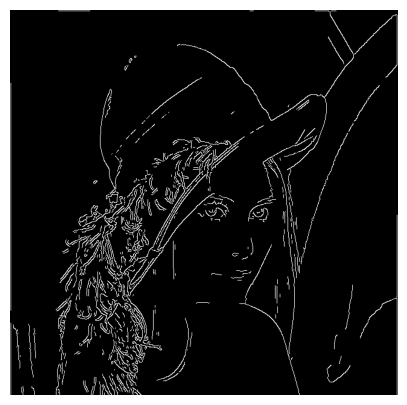

In [195]:
sobel_img = cv.Canny(blank_img,lower,upper,apertureSize=3 ,L2gradient=True)
display(sobel_img)

# Marr Hilreth Algorithm
Deriving the Laplacian of Gaussian(LoG):\
$\Delta^{2}g(x,y)$=-$\frac{1}{\sqrt{2\pi}\sigma^3}(2-\frac{x^2+y^2}{\sigma^2})e^{-\frac{x^2+y^2}{2\sigma^2}}$
- Compute LoG
    - Use 2D filter &Delta;$^{2}g(x,y)$
    - Use 4 1D filters $g(x), g_{xx}(x), g(y),g_{yy}(y)$
- Find zero-crossings from each row
- Find slope of zero-crossings
    - Compute slope
    - Apply a threshold to slope to mark an edge


Use separability for LoG for computation:\
$\Delta^2S=(I* g_{yy}(y)*g(x)+I* g_{xx}(x)*g(y))$
- Link for more information: https://www.youtube.com/watch?v=k-SXNpvHkc0


In [17]:
def edgesMarrHildreth(img, sigma):
    """
            finds the edges using MarrHildreth edge detection method...
            :param im : input image
            :param sigma : sigma is the std-deviation and refers to the spread of gaussian
            :return:
            a binary edge image...
    """
    size = int(2*(np.ceil(3*sigma))+1)

    x, y = np.meshgrid(np.arange(-size/2+1, size/2+1),
                       np.arange(-size/2+1, size/2+1))

    normal = 1 / (2.0 * np.pi * sigma**2)

    kernel = ((x**2 + y**2 - (2.0*sigma**2)) / sigma**4) * \
        np.exp(-(x**2+y**2) / (2.0*sigma**2)) / normal  # LoG filter

    kern_size = kernel.shape[0]
    log = np.zeros_like(img, dtype=float)

    # applying filter
    for i in range(img.shape[0]-(kern_size-1)):
        for j in range(img.shape[1]-(kern_size-1)):
            window = img[i:i+kern_size, j:j+kern_size] * kernel
            log[i, j] = np.sum(window)

    log = log.astype(np.int64, copy=False)

    zero_crossing = np.zeros_like(log)

    # computing zero crossing
    for i in range(log.shape[0]-(kern_size-1)):
        for j in range(log.shape[1]-(kern_size-1)):
            if log[i][j] == 0:
                if (log[i][j-1] < 0 and log[i][j+1] > 0) or (log[i][j-1] < 0 and log[i][j+1] < 0) or (log[i-1][j] < 0 and log[i+1][j] > 0) or (log[i-1][j] > 0 and log[i+1][j] < 0):
                    zero_crossing[i][j] = 255
            if log[i][j] < 0:
                if (log[i][j-1] > 0) or (log[i][j+1] > 0) or (log[i-1][j] > 0) or (log[i+1][j] > 0):
                    zero_crossing[i][j] = 255

    # plotting images
    fig = plt.figure()
    a = fig.add_subplot(1, 2, 1)
    plt.imshow(log, cmap='gray')
    a.axis('off')
    a.set_title('Laplacian of Gaussian')
    a = fig.add_subplot(1, 2, 2)
    plt.imshow(zero_crossing, cmap='gray')
    string = 'Zero Crossing sigma = '
    string += (str(sigma))
    a.axis('off')
    a.set_title(string)
    plt.show()

In [ ]:
log, zero_crossing = edgesMarrHildreth(blank_img, 1)

# Non-Maximal Supression
Link:   https://www.youtube.com/watch?v=Z_HwkG90Yvw&list=PL2zRqk16wsdqXEMpHrc4Qnb5rA1Cylrhx&index=7&t=651s (11:41s)